<table style="margin-left: 0;">
    <tr>
        <td colspan="5" style="text-align: center;"><h2><b>Portfolio 2 - Deep Learning</b></h2></td>
    </tr>
    <tr>
        <th>Coach</th>
        <th>Opdrachtnummer</th>
        <th>Namen groepsleden</th>
        <th>Kaggle naam</th>
    </tr>
    <tr>
        <td><span style="color:blue">Vikram en Bob</span></td>
        <td><span style="color:blue">2</span></td>
        <td>
            <ul style="list-style-type:none; padding-left:0;">
                <li><b>Mark Olieman:</b> <span style="color:green">19054033</span></li>
                <li><b>Johan Heskes:</b> <span style="color:green">22132376</span></li>
                <li><b>Henry Lau:</b> <span style="color:green">22122958</span></li>
                <li><b>Isa Dijkstra:</b> <span style="color:green">22119485</span></li>
            </ul>
        </td>
        <td><span style="color:blue">???</span></td>
    </tr>
</table>

    
    
## Inhoudsopgave

- [**Inleiding**](#inleiding)
- [**Packages en de data inladen**](#data)
- [**Opdracht 1 - EDA**](#eda)
- [**Opdracht 2 - LSTM voor audioclips**](#audio)
- [**Opdracht 3 - LSTM voor songteksten**](#song_lstm)
- [**Opdracht 4 - Transformer voor songteksten**](#song_tran)
- [**Opdracht 5 - Model naar keuze**](#mnk)
- [**Opdracht 6 - Bevindingen**](#bevindingen)
- [**Opdracht 7 - Conclusie en aanbevelingen**](#conclusie)
- [**Bronnenlijst**](#bronnenlijst)

## Inleiding <a name='inleiding'></a>

In dit notebook gaan we aan de hand van songteksten en audiodata, audiotracks in verschillende genres classificeren

## Packages en de data inladen <a name='data'></a>

In [1]:
!pip install datasets
!pip install transformers
import os
import re
import nltk
from nltk.tokenize import word_tokenize
import string
import pathlib
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython.display import display
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Embedding, TextVectorization
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, create_optimizer, TFAutoModelForSequenceClassification
from datasets import Dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/Portfolio opdracht 2')

In [4]:
#songteksten inladen

train = pd.read_csv('train.csv', index_col='filename')
test = pd.read_csv('test.csv', index_col='filename')

In [5]:
test


,lyrics
filename,
test.00000.wav,[Instrumental Intro]\n(Radio)\n(Radio)\n[Verse...
test.00001.wav,[Verse 1]\nThere's an old Kodak camera in my d...
test.00002.wav,"[Intro]\nSo curious, so curious\n\n[Verse 1]\n..."
test.00003.wav,[Intro]\nWhere do I take this pain of mine\nI ...
test.00004.wav,"[Verse 1]\nBaby's into runnin' around, hangin'..."
...,...
test.00124.wav,Heaven must be missing an angel\nMissing one a...
test.00125.wav,[Verse 1]\nLaura and Tommy were lovers\nHe wan...
test.00126.wav,"[Chorus: Agnetha & Frida, Benny & Björn]\nIf y..."


In [6]:
#Train en validation set inladen

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Train',
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=5*16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [7]:
len(label_names)

8

In [8]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
#test dataset inladen

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Test',
    label_mode=None,
    batch_size=32,
    seed=0,
    output_sequence_length=5*16000)

print()

Found 129 files belonging to 1 classes.



In [10]:
train_ds = train_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## **Opdracht 1 - EDA** <a name='eda'></a>

In [11]:
display(train.head())
display(train.describe())
display(train.isnull().sum())

,lyrics,genre
filename,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
blues.00006.wav,My baby left me this morning\nPeople just arou...,blues


,lyrics,genre
count,537,537
unique,500,8
top,"[Intro: Lil' Kim, Mýa, Christina Aguilera & P!...",rock
freq,4,79


lyrics    0
genre     0
dtype: int64

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets and their contents
    punctuation = string.punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)  # Remove punctuation
    return text

df_test = train.copy()
df_test['prep_text'] = df_test['lyrics'].apply(preprocess_text)
display(df_test)

,lyrics,genre,prep_text
filename,,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues,i’m in the mood lyrics im in the mood baby im ...
blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues,john lee hooker think twice before you go baby...
blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues,a little thing im going to do called im bad l...
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,sugar mama sugar mama sugar mama please come b...
blues.00006.wav,My baby left me this morning\nPeople just arou...,blues,my baby left me this morning people just aroun...
...,...,...,...
rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock,don’t stop isn’t it funny how you shine don’t...
rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock,her hair soft drifted snow death white id lik...
rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock,your knuckles whiten on the wheel the last th...


In [13]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets and their contents
    punctuation = string.punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)  # Remove punctuation
    return text

def tokenize_text(text):
    return text.split()

def count_tokens(text):
    return Counter(text)

df_test['prep_text'] = df_test['lyrics'].apply(preprocess_text)

# Combine all lyrics
all_lyrics = ' '.join(df_test['prep_text'])

# Tokenize combined text
all_tokens = tokenize_text(all_lyrics)

# Count occurrences of each token
token_counts = count_tokens(all_tokens)

# Get the most common tokens
most_common_all_genres = token_counts.most_common(20)  # You can adjust this number as needed


grouped_by_genre = df_test.groupby('genre')

#Calculate frequency distribution of tokens and extract most common tokens per genre
most_common_per_genre = {}
for genre, group in grouped_by_genre:
    all_tokens = [token for text in group['prep_text'] for token in tokenize_text(text)]
    token_counts = count_tokens(all_tokens)
    most_common = token_counts.most_common(20)  # You can adjust this number as needed
    most_common_per_genre[genre] = most_common

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


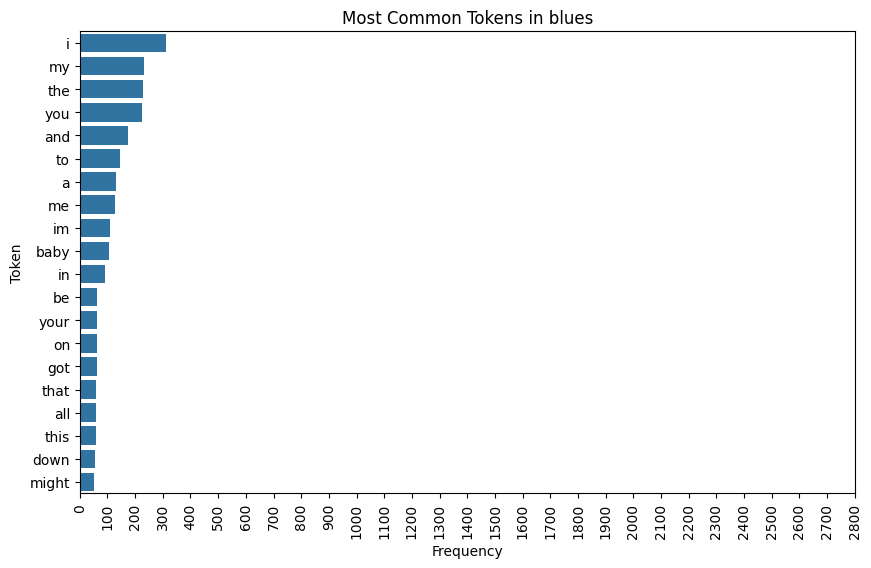

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


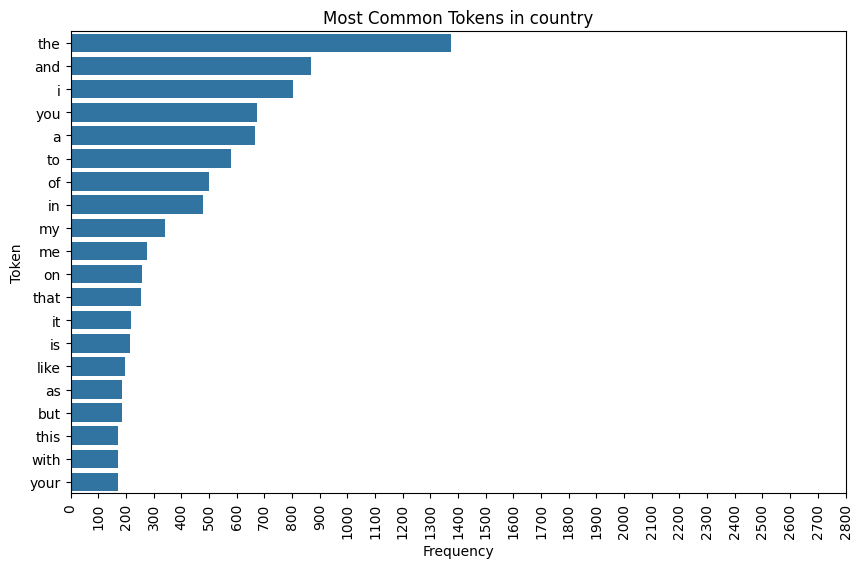

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


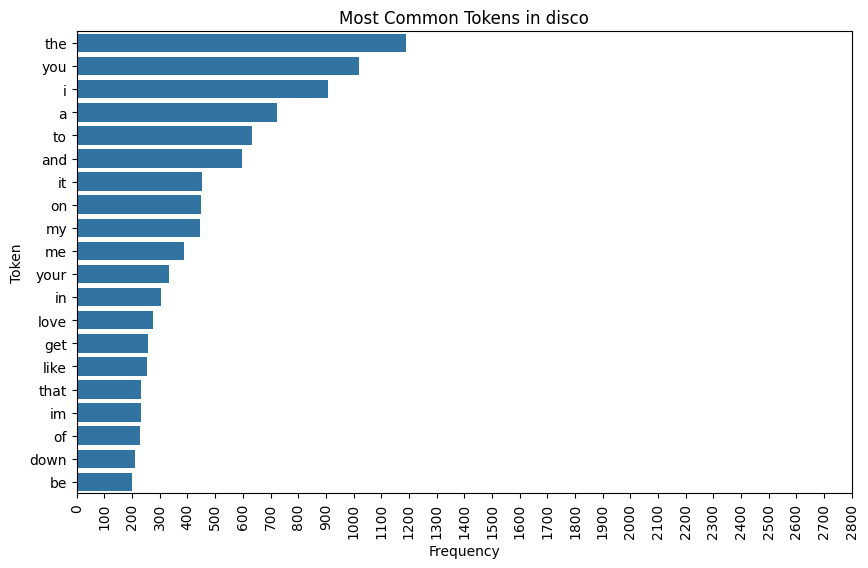

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


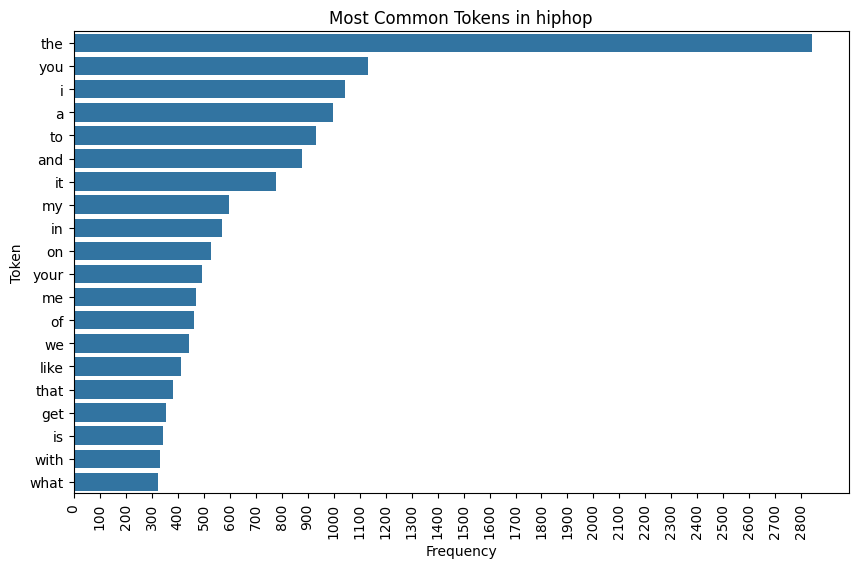

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


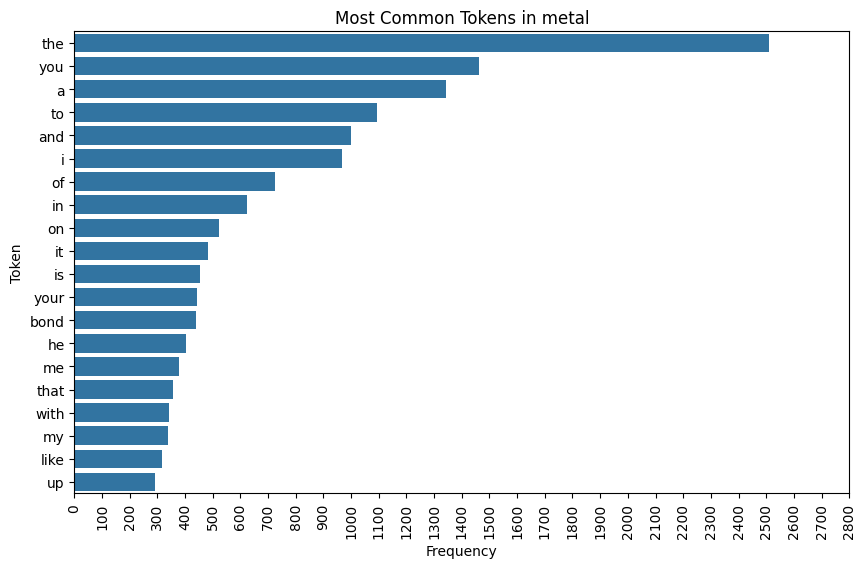

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


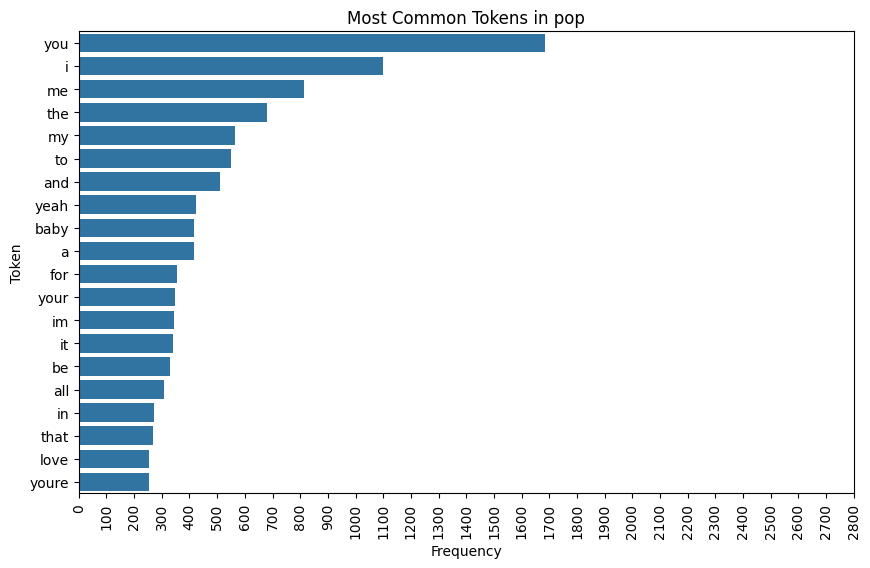

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


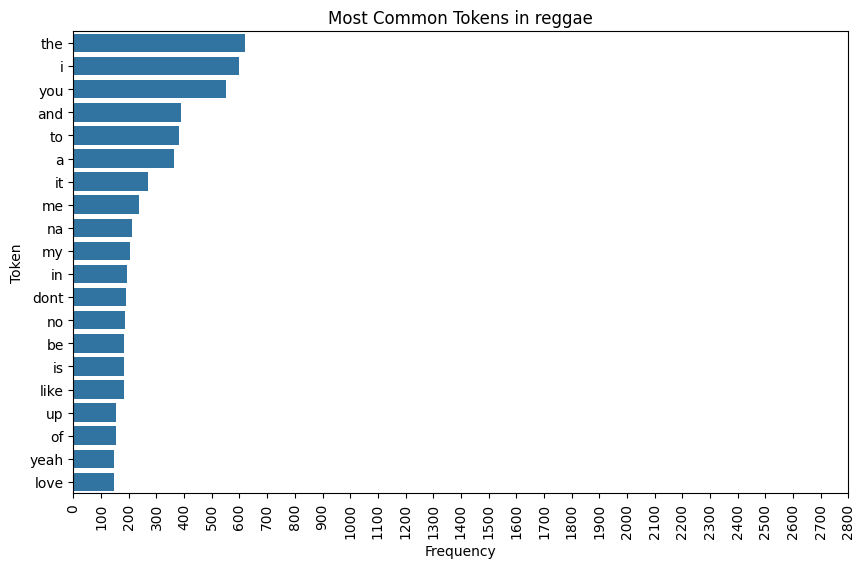

<ipython-input-14-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


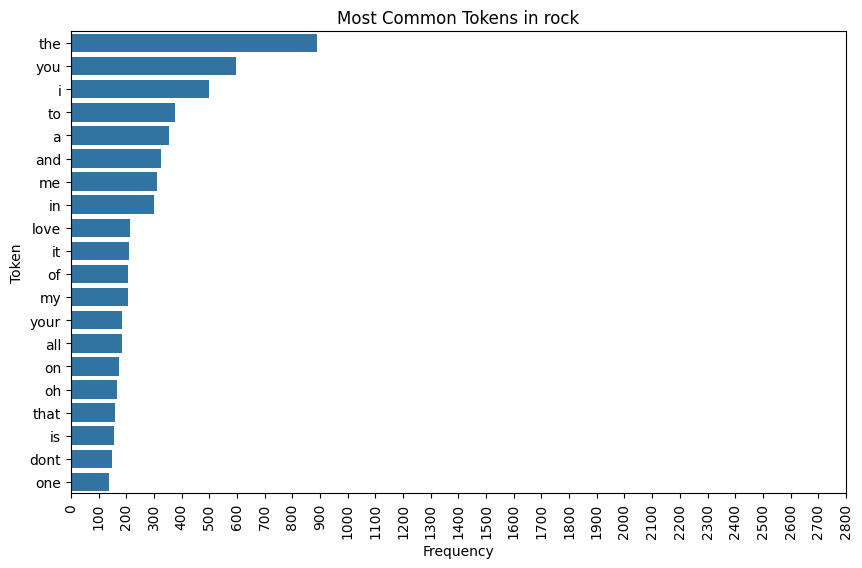

<ipython-input-14-44e37876299c>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts_all, y=tokens_all, ci=None)


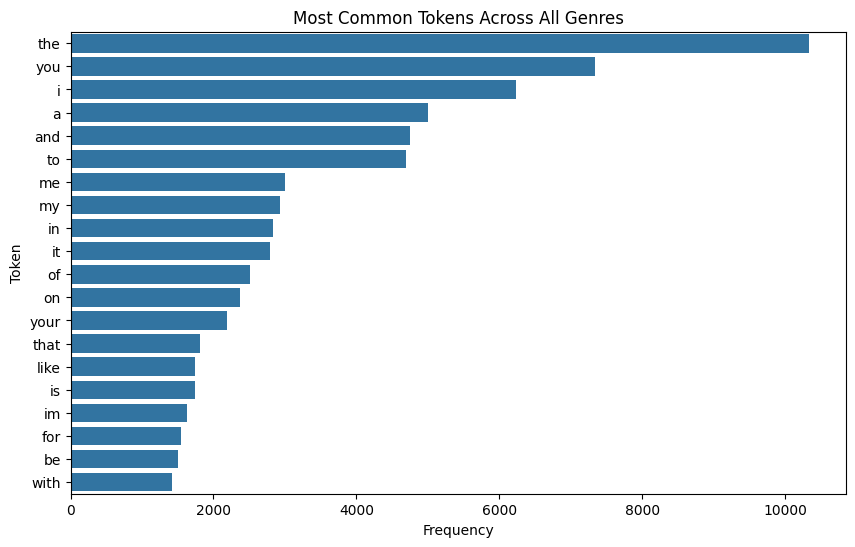

In [14]:
max_count = max(max(sublist[1] for sublist in sublist_list) for sublist_list in most_common_per_genre.values())
x_ticks = np.arange(0, max_count + 1, 100)

# Plot most common tokens per genre
for genre, common_tokens in most_common_per_genre.items():
    tokens, counts = zip(*common_tokens)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=tokens, ci=None)
    plt.title(f"Most Common Tokens in {genre}")
    plt.xlabel("Frequency")
    plt.ylabel("Token")
    plt.xticks(x_ticks, rotation=90)
    plt.show()

# Plot most common tokens across all genres
tokens_all, counts_all = zip(*most_common_all_genres)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts_all, y=tokens_all, ci=None)
plt.title("Most Common Tokens Across All Genres")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()

(32, 80000)
(32,)


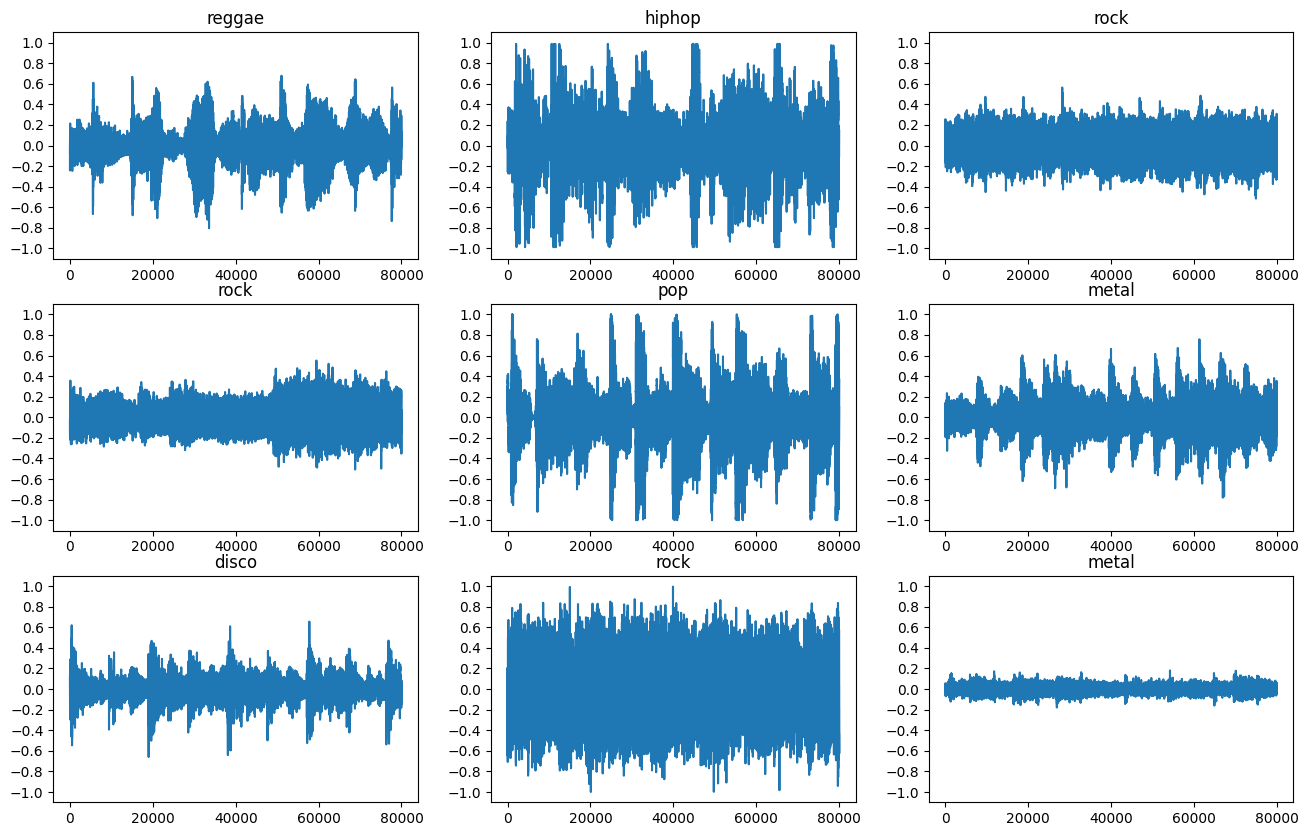

In [15]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

label_names[[1,1,0,0]]
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## Opdracht 2 - LSTM voor audioclips <a name='audio'></a>

In [ ]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Obtain the magnitude of the STFT (use tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [ ]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [ ]:
#even kijken of het zo werkt
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio: (get_spectrogram(audio),),  # Geen label doorgeven
      num_parallel_calls=tf.data.AUTOTUNE)

test_spectrogram_ds = make_spec_ds(test_ds)


In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=13, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    return mfccs

In [ ]:
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram,label: (spectrogram_to_mfcc(spectrogram), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)

In [ ]:
#even kijken of het zo werkt
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram: (spectrogram_to_mfcc(spectrogram)),
      num_parallel_calls=tf.data.AUTOTUNE)

test_MFCC_ds = make_MFCC_ds(test_spectrogram_ds)

In [ ]:
train_MFCC_ds = train_MFCC_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)
test_MFCC_ds = test_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(8, activation='softmax')
])


In [ ]:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

Epoch 1/50


14/14 [==============================] - 14s 342ms/step - loss: 1.9979 - accuracy: 0.1930 - val_loss: 1.8618 - val_accuracy: 0.2523
Epoch 2/50
14/14 [==============================] - 3s 195ms/step - loss: 1.7571 - accuracy: 0.3837 - val_loss: 1.7240 - val_accuracy: 0.3271
Epoch 3/50
14/14 [==============================] - 3s 215ms/step - loss: 1.5897 - accuracy: 0.4279 - val_loss: 1.6516 - val_accuracy: 0.3551
Epoch 4/50
14/14 [==============================] - 3s 192ms/step - loss: 1.4740 - accuracy: 0.4628 - val_loss: 1.5947 - val_accuracy: 0.3645
Epoch 5/50
14/14 [==============================] - 3s 188ms/step - loss: 1.3745 - accuracy: 0.5070 - val_loss: 1.5529 - val_accuracy: 0.3364
Epoch 6/50
14/14 [==============================] - 3s 199ms/step - loss: 1.2721 - accuracy: 0.5233 - val_loss: 1.5056 - val_accuracy: 0.3925
Epoch 7/50
14/14 [==============================] - 3s 183ms/step - loss: 1.1730 - accuracy: 0.5605 - val_loss: 1.4851 - val_accuracy: 0.4112
Epo

In [ ]:
del model_lstm
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

Epoch 1/50
14/14 [==============================] - 10s 268ms/step - loss: 1.9956 - accuracy: 0.2209 - val_loss: 1.9216 - val_accuracy: 0.2804
Epoch 2/50
14/14 [==============================] - 2s 174ms/step - loss: 1.7430 - accuracy: 0.3651 - val_loss: 1.7759 - val_accuracy: 0.3271
Epoch 3/50
14/14 [==============================] - 2s 175ms/step - loss: 1.6015 - accuracy: 0.4302 - val_loss: 1.7377 - val_accuracy: 0.3551
Epoch 4/50
14/14 [==============================] - 2s 179ms/step - loss: 1.5026 - accuracy: 0.4791 - val_loss: 1.6539 - val_accuracy: 0.4112
Epoch 5/50
14/14 [==============================] - 3s 222ms/step - loss: 1.3561 - accuracy: 0.5395 - val_loss: 1.6665 - val_accuracy: 0.3645
Epoch 6/50
14/14 [==============================] - 3s 219ms/step - loss: 1.2452 - accuracy: 0.5628 - val_loss: 1.6120 - val_accuracy: 0.3645
Epoch 7/50
14/14 [==============================] - 3s 201ms/step - loss: 1.1508 - accuracy: 0.6302 - val_loss: 1.4951 - val_accuracy: 0.4299
Epoch

In [ ]:
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32, return_sequences=True)),  # Extra LSTM-laag met return_sequences=True
    Dropout(0.2),
    Bidirectional(LSTM(units=16)),  # Nog een LSTM-laag zonder return_sequences=True
    Dropout(0.2),
    Dense(64, activation='relu'),  # Extra dense-laag
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 10
history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
)

Epoch 1/10
14/14 [==============================] - 15s 388ms/step - loss: 2.0384 - accuracy: 0.1674 - val_loss: 1.9572 - val_accuracy: 0.3364
Epoch 2/10
14/14 [==============================] - 4s 306ms/step - loss: 1.8930 - accuracy: 0.3279 - val_loss: 1.8353 - val_accuracy: 0.3271
Epoch 3/10
14/14 [==============================] - 5s 345ms/step - loss: 1.7987 - accuracy: 0.3419 - val_loss: 1.7459 - val_accuracy: 0.3551
Epoch 4/10
14/14 [==============================] - 6s 447ms/step - loss: 1.6998 - accuracy: 0.3698 - val_loss: 1.6844 - val_accuracy: 0.3271
Epoch 5/10
14/14 [==============================] - 5s 367ms/step - loss: 1.5938 - accuracy: 0.4163 - val_loss: 1.6271 - val_accuracy: 0.3551
Epoch 6/10
14/14 [==============================] - 5s 344ms/step - loss: 1.5313 - accuracy: 0.4628 - val_loss: 1.5906 - val_accuracy: 0.3458
Epoch 7/10
14/14 [==============================] - 7s 476ms/step - loss: 1.3950 - accuracy: 0.4698 - val_loss: 1.6172 - val_accuracy: 0.3925
Epoch

In [ ]:
del model_lstm
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)


Epoch 1/50
14/14 [==============================] - 25s 802ms/step - loss: 1.9946 - accuracy: 0.2000 - val_loss: 1.8622 - val_accuracy: 0.3084
Epoch 2/50
14/14 [==============================] - 9s 631ms/step - loss: 1.8361 - accuracy: 0.3279 - val_loss: 1.7310 - val_accuracy: 0.3458
Epoch 3/50
14/14 [==============================] - 8s 589ms/step - loss: 1.7161 - accuracy: 0.4000 - val_loss: 1.6639 - val_accuracy: 0.3551
Epoch 4/50
14/14 [==============================] - 8s 597ms/step - loss: 1.6158 - accuracy: 0.4140 - val_loss: 1.5829 - val_accuracy: 0.3738
Epoch 5/50
14/14 [==============================] - 8s 586ms/step - loss: 1.5259 - accuracy: 0.4395 - val_loss: 1.5788 - val_accuracy: 0.3645
Epoch 6/50
14/14 [==============================] - 8s 596ms/step - loss: 1.3972 - accuracy: 0.4791 - val_loss: 1.5227 - val_accuracy: 0.3738
Epoch 7/50
14/14 [==============================] - 8s 607ms/step - loss: 1.3520 - accuracy: 0.5395 - val_loss: 1.5153 - val_accuracy: 0.3645
Epoch

Text(0, 0.5, 'Accuracy [%]')

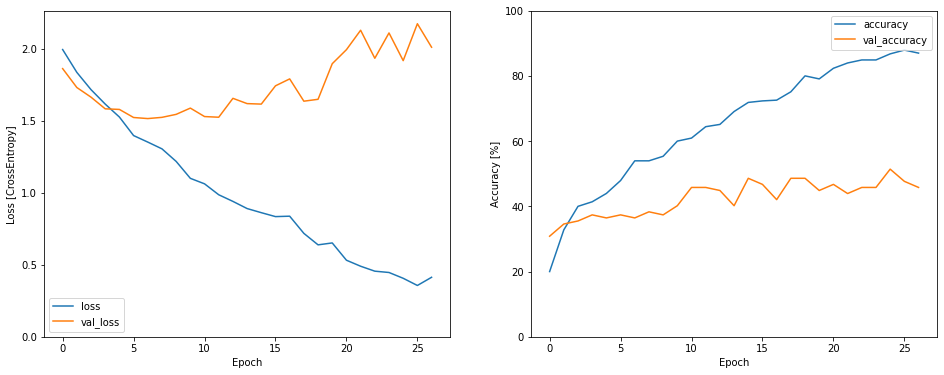

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Opdracht 3 - LSTM voor songteksten <a name='song_lstm'></a>

Alle code is gemaakt met behulp van ChatGPT.  
[Preprocess text](https://chat.openai.com/share/23851467-f3c1-4ab7-a520-ce6f3e93bc8d)  
[LSTM Model Input Error](https://chat.openai.com/share/87bf7e53-56c5-4fd7-ac24-236f9f47ebf9)  
[Lower text](https://chat.openai.com/share/3d02c6cd-6317-4eb8-a171-864d7a67873c)  
[Model error](https://chat.openai.com/share/1ab1e7fb-5b2f-41c9-8c28-182b9d584c50)  
[Text Preprocessing & Embedding](https://chat.openai.com/share/14b384fc-55f4-4ef3-b5df-699f256dc903)  
[Preprocess Text: Corrections Made](https://chat.openai.com/share/9a0924be-1a99-4e08-b269-fa10cb08b4b1)  
[Overfitting indicated by loss and accuracy score](https://chat.openai.com/share/fc5c120f-dc1f-4203-ab43-9c111367aeb3)  



De dataframe heeft als index de filename en de kollomen zijn lyrics en genre. We maken gebruik van LabelEncoder om een encoded genre te maken, zodat de target/labels numeriek zijn.

In [16]:
genres = list(set(train['genre']))

label_encoder = LabelEncoder()

# Fit label encoder and transform the genre labels into numbers
encoded_labels = label_encoder.fit_transform(genres)

# Print the mapping between genres and encoded labels
label_mapping = dict(sorted(zip(genres, encoded_labels)))
print("Label mapping:", label_mapping)

train['genre_encoded'] = train['genre'].map(label_mapping)

display(train)

Label mapping: {'blues': 0, 'country': 1, 'disco': 2, 'hiphop': 3, 'metal': 4, 'pop': 5, 'reggae': 6, 'rock': 7}


,lyrics,genre,genre_encoded
filename,,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues,0
blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues,0
blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues,0
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,0
blues.00006.wav,My baby left me this morning\nPeople just arou...,blues,0
...,...,...,...
rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock,7
rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock,7
rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock,7


In [17]:
def df_to_dataset(dataframe, target, num_classes, batch_size=32, shuffle=True):
    '''Takes a dataframe with lyrics, target and number of classes to turn them to a training and validation dataset.

    Parameters:
    -----------
      dataframe: Dataframe.
      target: str, target column (labels).
      num_classes: int, amount of set classes.

    Returns:
    --------
      train_ds: tensorflow.python.data.ops.batch_op._BatchDataset, training dataset.
      val_ds: tensorflow.python.data.ops.batch_op._BatchDataset, validation dataset.
    '''
    dataframe = dataframe.copy()
    if shuffle:
      dataframe = dataframe.reset_index().sample(frac=1).set_index('filename')

    train_size = int(0.8 * len(dataframe))

    # Split dataframe into training and validation sets
    train_df = dataframe[:train_size]
    val_df = dataframe[train_size:]
    train_labels = to_categorical(train_df.pop(target), num_classes)
    val_labels = to_categorical(val_df.pop(target), num_classes)

    train_ds = tf.data.Dataset.from_tensor_slices((train_df['lyrics'].values, train_labels))
    train_ds = train_ds.batch(batch_size)

    val_ds = tf.data.Dataset.from_tensor_slices((val_df['lyrics'].values, val_labels))
    val_ds = val_ds.batch(batch_size)
    return train_ds, val_ds

In [18]:
dataframe = train[['lyrics', 'genre_encoded']]
num_classes = len(set(dataframe['genre_encoded']))
train_text_ds, val_text_ds = df_to_dataset(dataframe, 'genre_encoded', num_classes)

Voor de vectorize layer is er een custom_standardization functie gemaakt om de lyrics te preprocessen. De preprocessing bestaat uit:  
1. Alles uit de text tot klein letters gemaakt.
2. Alle new lines (\n) verplaats met een spatie.
3. Alles in rechte haakjes verplaats met een spatie (Er wordt in rechte haakjes de Chorus, Verse of andere termen gewezen).
4. Alle leestekens weggehaald.  
  
We hebben dan schonere teksten voor de vectorize layer, met max_tokens en output_sequence_length hopen we voor een goede kwaliteit van de vectorize layer.  
De embedding layer is om voor elk woord een dense vector te maken, zodat de woorden een connectie hebben met elkaar.


In [19]:
def custom_standardization(text):
    # Lowercase text
    text = tf.strings.lower(text)
    # Remove new lines
    text = tf.strings.regex_replace(text, r'\n', ' ')
    # Remove anything in square brackets
    text = tf.strings.regex_replace(text, r'\[.*?\]', '')
    # Remove punctuation
    punctuation = string.punctuation
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(punctuation), '')
    return text

vocab_size = 10000
sequence_length = 120

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_text_ds.map(lambda x, y: x)
text_ds = text_ds.unbatch()  # Unbatch the dataset to get individual text samples

# Extract the text data from the dataset
texts = [text.numpy().decode('utf-8') for text in text_ds]
vectorize_layer.adapt(texts)

embedding_layer = Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64, mask_zero=True)

In [20]:
model_text_lstm = Sequential([
    vectorize_layer,
    embedding_layer,
    GRU(128, return_sequences=True, dropout=0.2),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_text_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 64)           640000    
                                                                 
 gru (GRU)                   (None, 120, 128)          74496     
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 5

Het model bestaat eerst uit vectorized_layer en embedding_layer, daarna hebben we willekeurig een GRU en Bidrectional met LSTM layers geplaatst. Dan een Dense naar een output met softmax als activation, omdat we te maken hebben met multiple classes. In dit geval 8.

In [21]:
epochs=50

# Compile
model_text_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['accuracy'])

# Add early stopping to the tuning process
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train
history = model_text_lstm.fit(train_text_ds,
                              batch_size = 32,
                                validation_data=val_text_ds,
                                epochs=epochs)

Epoch 1/50
14/14 [==============================] - 24s 1s/step - loss: 2.0786 - accuracy: 0.1259 - val_loss: 2.0744 - val_accuracy: 0.1574
Epoch 2/50
14/14 [==============================] - 13s 956ms/step - loss: 2.0587 - accuracy: 0.1608 - val_loss: 2.0682 - val_accuracy: 0.1667
Epoch 3/50
14/14 [==============================] - 14s 1s/step - loss: 1.9781 - accuracy: 0.2401 - val_loss: 2.0850 - val_accuracy: 0.1944
Epoch 4/50
14/14 [==============================] - 12s 877ms/step - loss: 1.6761 - accuracy: 0.3590 - val_loss: 2.0163 - val_accuracy: 0.2130
Epoch 5/50
14/14 [==============================] - 12s 868ms/step - loss: 1.3048 - accuracy: 0.5291 - val_loss: 2.4328 - val_accuracy: 0.1852
Epoch 6/50
14/14 [==============================] - 12s 859ms/step - loss: 1.0235 - accuracy: 0.6783 - val_loss: 2.2057 - val_accuracy: 0.2778
Epoch 7/50
14/14 [==============================] - 12s 891ms/step - loss: 0.8386 - accuracy: 0.6760 - val_loss: 2.5967 - val_accuracy: 0.2222
Epoch

Willekeurig 5000 epochs gekozen om te zien hoe ver de training gaat. De EarlyStopping monitor de val_loss en heeft de training gestopt in 5 epochs. So we hebben besloten om 50 epochs te runnen.

Text(0, 0.5, 'Accuracy [%]')

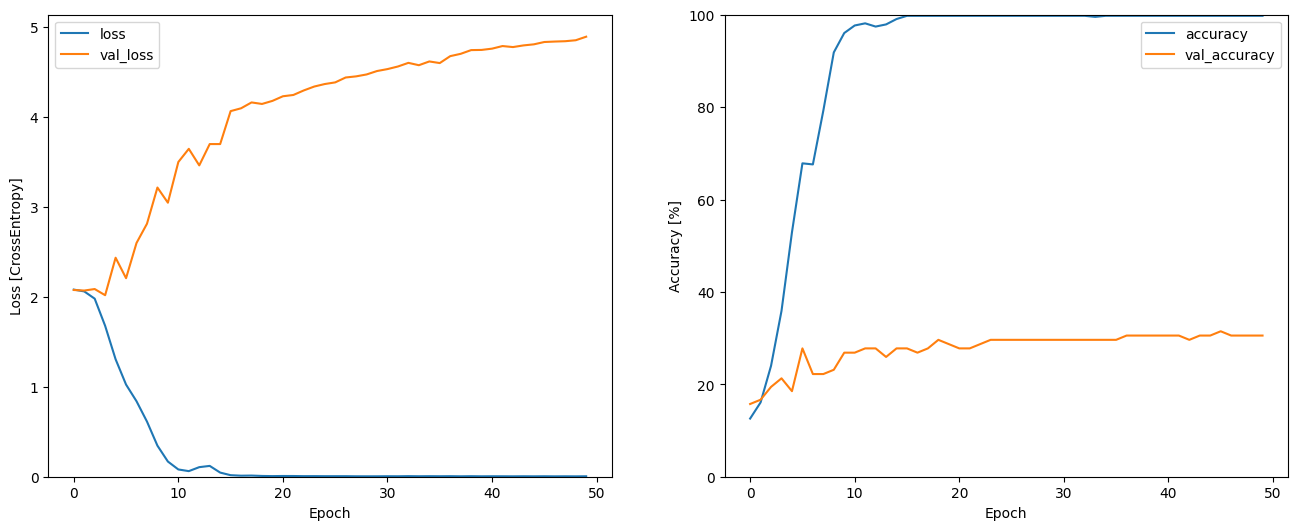

In [22]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Opdracht 4 - Transformer voor songteksten <a name='song_tran'></a>

## BERT model
Voor deze opdracht gebruiken wij het BERT model, dit is een vrij klein model wat goed is omdat het lokaal gerunt kan worden. Ook is het een transformer model dat getrained is op een grote dataset van text waardoor het model goede generalisaties in text kan herkennen en dus beter is in het voorspellen van genres gebaseerd op lyrics. Het model gebruikt de voorgetrainde kennis om de voorspellingen goed uit te kunnen voeren zonder hier enorme hoeveelheden data voor nodig te hebben.

### Modelnaam
model: bert-base-uncased

### Training data
Het BERT-model werd vooraf getraind op BookCorpus, een dataset bestaande uit 11.038 niet-gepubliceerde boeken en de Engelstalige Wikipedia (zonder lijsten, tabellen en kopteksten).

BookCorpus: https://yknzhu.wixsite.com/mbweb<br>
English Wikipedia: https://en.wikipedia.org/wiki/English_Wikipedia

In [ ]:
batch_size = 8
num_train_epochs = 15
num_train_steps = (len(train['lyrics']) // batch_size) * num_train_epochs
label2id = label_dict = train[['genre', 'genre_encoded']].drop_duplicates().set_index('genre').to_dict()['genre_encoded']
id2label = {i: label for label, i in label_dict.items()}

In [ ]:
model_checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
train['tokenized'] = train['lyrics'].apply(lambda lyrics: tokenizer(lyrics, truncation=True, padding='max_length', max_length=512)['input_ids'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

train_data, eval_data = train_test_split(train, test_size=0.2)

train_dataset = Dataset.from_pandas(train_data).to_tf_dataset(
    columns=['tokenized'],
    label_cols=["genre_encoded"],
    shuffle=True,
    batch_size=batch_size,
)

eval_dataset = Dataset.from_pandas(eval_data).to_tf_dataset(
    columns=['tokenized'],
    label_cols=["genre_encoded"],
    shuffle=True,
    batch_size=batch_size,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


## Training/fine-tuning het BERT model op de train dataset
Voor het finetunen van het BERT model op de songteksten is eerst de dataset ingeladen en zijn de labels ge-encoded naar nummerieke data zodat dit gebruikt kan worden. Daarna is door de AutoTokenizer de song lyrics getokenized en deze worden vervolgens omgezet naar een Tensorflow dataset met de kolom 'tokenized' (de getokenizede lyrics) als columns en 'genre_encoded' (de numerieke genres) als label_cols. Dit gebeurd allemaal in cellen hierboven

Als laatst is het alleen nog noodzakelijk een optimizer te definieren en het model te trainen. Dit gebeurd in de cel hieronder

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=len(label2id), id2label=id2label, label2id=label2id
)


optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

model.compile(optimizer=optimizer)

model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=num_train_epochs
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
54/54 [==============================] - 141s 1s/step - loss: 2.0104 - val_loss: 1.8666
Epoch 2/15
54/54 [==============================] - 62s 1s/step - loss: 1.8693 - val_loss: 1.6955
Epoch 3/15
21/54 [==========>...................] - ETA: 35s - loss: 1.7683

## Opdracht 5 - Model naar keuze <a name='mnk'></a>

## Opdracht 6 - Bevindingen <a name='bevindingen'></a>

|model|loss|val loss|accuracy|val accuracy|  
|-----|----|--------|--------|------------|
|LSTM voor audioclips|0.4132|2.0107|0.8698|0.4579|  
|LSTM voor songteksten|0.0050|4.8882|0.9977|0.3056|  
|Transformer voor songteksten|||||  
|Model naar keuze|||||  


### LSTM voor audioclips  
Het model loss is gezakt naar 0.4132, terwijl de val loss omhoog is gegaan naar 2.0107 tijdens het trainen. Dit geeft aan dat het model is gaan overfitten. Vandaar de val accuracy wat lager zit dan de accuracy. Dus het model presteert slechter met data dat het model niet kent.  
### LSTM voor songteksten  
Hier geldt hetzelfde als bij LSTM voor audioclips. Alleen slechter volgens de scores.  
### Transformer voor songteksten  

### Model naar keuze  


## Opdracht 7 - Conclusie en aanbevelingen <a name='conclusie'></a>

## Bronnenlijst <a name='bronnenlijst'></a>